In [ ]:
# default_exp losses.pytorch

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import torch as t
import torch.nn as nn

In [ ]:
#export
def divide_no_nan(a, b):
    """
    Auxiliary funtion to handle divide by 0
    """
    div = a / b
    div[div != div] = 0.0
    div[div == float('inf')] = 0.0
    return div

#############################################################################
# FORECASTING LOSSES
#############################################################################

def MAPELoss(y, y_hat, mask=None):
    """MAPE Loss

    Calculates Mean Absolute Percentage Error between
    y and y_hat. MAPE measures the relative prediction
    accuracy of a forecasting method by calculating the
    percentual deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.
    mask: tensor (batch_size, output_size)
        specifies date stamps per serie
        to consider in loss

    Returns
    -------
    mape:
    Mean absolute percentage error.
    """
    mask = divide_no_nan(mask, t.abs(y))
    mape = t.abs(y - y_hat) * mask
    mape = t.mean(mape)
    return mape

# def MAPELoss(forecast: t.Tensor, target: t.Tensor, mask: t.Tensor):
#     """
#     MAPE loss as defined in: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

#     :param forecast: Forecast values. Shape: batch, time
#     :param target: Target values. Shape: batch, time
#     :param mask: 0/1 mask. Shape: batch, time
#     :return: Loss value
#     """
#     weights = divide_no_nan(mask, target)
#     return t.mean(t.abs((forecast - target) * weights))

def MSELoss(y, y_hat, mask=None):
    """MSE Loss

    Calculates Mean Squared Error between
    y and y_hat. MAPE measures the relative prediction
    accuracy of a forecasting method by calculating the
    percentual deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.
    mask: tensor (batch_size, output_size)
        specifies date stamps per serie
        to consider in loss

    Returns
    -------
    mse:
    Mean Squared Error.
    """
    mse = (y - y_hat)**2
    mse = mask * mse
    mse = t.mean(mse)
    return mse

def RMSELoss(y, y_hat, mask=None):
    """RMSE Loss

    Calculates Mean Squared Error between
    y and y_hat. MAPE measures the relative prediction
    accuracy of a forecasting method by calculating the
    percentual deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.
    mask: tensor (batch_size, output_size)
        specifies date stamps per serie
        to consider in loss

    Returns
    -------
    rmse:
    Root Mean Squared Error.
    """
    rmse = (y - y_hat)**2
    rmse = mask * rmse
    rmse = t.sqrt(t.mean(rmse))
    return rmse

def SMAPELoss(y, y_hat, mask=None):
    """SMAPE2 Loss

    Calculates Symmetric Mean Absolute Percentage Error.
    SMAPE measures the relative prediction accuracy of a
    forecasting method by calculating the relative deviation
    of the prediction and the true value scaled by the sum of the
    absolute values for the prediction and true value at a
    given time, then averages these devations over the length
    of the series. This allows the SMAPE to have bounds between
    0% and 200% which is desireble compared to normal MAPE that
    may be undetermined.

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.

    Returns
    -------
    smape:
        symmetric mean absolute percentage error

    References
    ----------
    [1] https://robjhyndman.com/hyndsight/smape/ (Makridakis 1993)
    """
    if mask is None:
        mask = t.ones(y_hat.size())
    delta_y = t.abs((y - y_hat))
    scale = t.abs(y) + t.abs(y_hat)
    smape = divide_no_nan(delta_y, scale)
    smape = smape * mask
    smape = 2 * t.mean(smape)
    return smape


def MASELoss(y, y_hat, y_insample, seasonality, mask=None) :
    """ Calculates the M4 Mean Absolute Scaled Error.

    MASE measures the relative prediction accuracy of a
    forecasting method by comparinng the mean absolute errors
    of the prediction and the true value against the mean
    absolute errors of the seasonal naive model.

    Parameters
    ----------
    seasonality: int
        main frequency of the time series
        Hourly 24,  Daily 7, Weekly 52,
        Monthly 12, Quarterly 4, Yearly 1
    y: tensor (batch_size, output_size)
        actual test values
    y_hat: tensor (batch_size, output_size)
        predicted values
    y_train: tensor (batch_size, input_size)
        actual insample values for Seasonal Naive predictions

    Returns
    -------
    mase:
        mean absolute scaled error

    References
    ----------
    [1] https://robjhyndman.com/papers/mase.pdf
    """
    if mask is None:
        mask = t.ones(y_hat.size())
    delta_y = t.abs(y - y_hat)
    scale = t.mean(t.abs(y_insample[:, seasonality:] - \
                            y_insample[:, :-seasonality]), axis=1)
    mase = divide_no_nan(delta_y, scale[:, None])
    mase = mase * mask
    mase = t.mean(mase)
    return mase

def MAELoss(y, y_hat, mask=None):
    """MAE Loss

    Calculates Mean Absolute Error between
    y and y_hat. MAE measures the relative prediction
    accuracy of a forecasting method by calculating the
    deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.
    mask: tensor (batch_size, output_size)
        specifies date stamps per serie
        to consider in loss

    Returns
    -------
    mae:
    Mean absolute error.
    """
    mae = t.abs(y - y_hat) * mask
    mae = t.mean(mae)
    return mae

def PinballLoss(y, y_hat, mask=None, tau=0.5):
    """Pinball Loss
    Computes the pinball loss between y and y_hat.

    Parameters
    ----------
    y: tensor (batch_size, output_size)
        actual values in torch tensor.
    y_hat: tensor (batch_size, output_size)
        predicted values in torch tensor.
    tau: float, between 0 and 1
        the slope of the pinball loss, in the context of
        quantile regression, the value of tau determines the
        conditional quantile level.

    Returns
    -------
    pinball:
        average accuracy for the predicted quantile
    """
    if mask is None:
        mask = t.ones(y_hat.size())
    delta_y = t.sub(y, y_hat)
    pinball = t.max(t.mul(tau, delta_y), t.mul((tau - 1), delta_y))
    pinball = pinball * mask
    pinball = t.mean(pinball)
    return pinball

In [ ]:
# export
def QuadraticBarrierLoss(z, tau):
    """
    Quadratic penalty as substitition to inequality constraints
    Learning to play in a day: Faster deep reinforcement learning by optimality tightening.
    """
    barrier = tau * t.max(t.zeros_like(z), z)**2
    loss = barrier.mean()
    return loss

# def LogbarrierLoss(z, t):
#     """
#     https://www.groundai.com/project/log-barrier-constrained-cnns/1
#     https://github.com/AnonymousICCVSubmission/extended_log_barrier/blob/master/losses.py
#     """
#     assert z.shape == ()

#     if z <= - 1 / t**2:
#         return - torch.log(-z) / t
#     else:
#         return t * z + -np.log(1 / (t**2)) / t + 1 / t

# Multi-quantile Loss

MQLoss definition and testing

In [ ]:
#export
def MQLoss(y, y_hat, quantiles, mask=None): 
    """MQLoss

    Calculates Average Multi-quantile Loss function, for
    a given set of quantiles, based on the absolute 
    difference between predicted and true values.

    Parameters
    ----------
    y: tensor (batch_size) actual values in torch tensor.
    y_hat: tensor (batch_size, n_quantiles) predicted values in torch tensor.
    mask: tensor (batch_size, n_quantiles) specifies date stamps per serie
          to consider in loss
    quantiles: tensor(n_quantiles) quantiles to estimate from the distribution of y.

    Returns
    -------
    lq: tensor(n_quantiles) average multi-quantile loss.
    """    
    
    if mask == None: mask = t.ones_like(y_hat)

    error = y_hat - y.unsqueeze(1)
    sq = t.maximum(-error, t.zeros_like(error))
    s1_q = t.maximum(error, t.zeros_like(error))
    loss = (quantiles * sq + (1 - quantiles) * s1_q) * mask
    return t.mean(t.sum(loss, dim=1))

In [ ]:
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

In [ ]:
class MQTestModel(nn.Module):  

    def __init__(self, n_quantiles):
        super(MQTestModel, self).__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=n_quantiles, bias=False)

    def forward(self, x):
        y_hat = self.linear_layer(x)
        return y_hat

In [ ]:
class DataTraining(Dataset):
    
    # Constructor
    def __init__(self, y, x):
        self.x = x
        self.y = y
        self.len = y.shape[0]

    # Getter
    def __getitem__(self, index):          
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

## Model testing

In [ ]:
import numpy as np
import time
from scipy.stats import hmean

In [ ]:
# Hyperparameters and sample data parameters

t.cuda.manual_seed(7)

# Sample data
n_obs = 10000
mean = 0.0 # to generate random numbers from N(mean, std)
std = 7.0 # to generate random numbers from N(mean, std)
start = 0.05 # First quantile
end = 0.95 # Last quantiles
steps = 4 # Number of quantiles

# Hyperparameters
batch_size = 500
lr = 0.08
epochs = 100

In [ ]:
# Sample data

quantiles = t.linspace(start=start, end=end, steps=steps) 
print(f'quantiles:\n{quantiles}')
y = t.normal(mean=mean, std=std, size=(n_obs,))
x = t.ones(size=(len(y), 1))
print(f'\ny.shape: {y.shape}, x.shape: {x.shape}')

quantiles:
tensor([0.0500, 0.3500, 0.6500, 0.9500])

y.shape: torch.Size([10000]), x.shape: torch.Size([10000, 1])


In [ ]:
# Model training 

model = MQTestModel(n_quantiles=len(quantiles))
dataset = DataTraining(x=x, y=y)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

def train_model(model, epochs, print_progress=False):

    start = time.time()
    i = 0 
    training_trajectory = [list(), list()]
    
    for epoch in range(epochs):
        for x, y in dataloader:
            
            i += 1
            y_hat = model(x)
            training_loss = MQLoss(y=y, y_hat=y_hat, quantiles=quantiles)
            if i % ((epochs * (n_obs / batch_size)) / 100) == 0: 
                training_trajectory[0].append(i)
                training_trajectory[1].append(training_loss.detach().numpy())
            optimizer.zero_grad()
            training_loss.backward()
            optimizer.step()

            display_string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(i, 
                                                                                    time.time()-start, 
                                                                                    "MQLoss", 
                                                                                    training_loss.cpu().data.numpy())
            if print_progress: print(display_string)

    return model, training_trajectory

trained_model = train_model(model=model, epochs=epochs)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

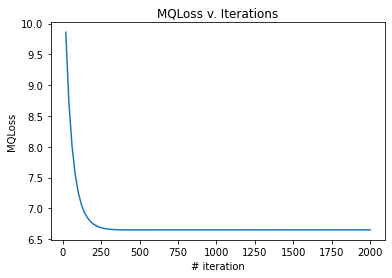

In [ ]:
plt.plot(trained_model[1][0], trained_model[1][1])
plt.xlabel('# iteration')
plt.ylabel('MQLoss')
plt.title('MQLoss v. Iterations')
plt.show()

In [ ]:
# Accuracy

def absolute_error(quantiles, y, y_hat):
    """accuracy

    Calculates the accuracy of the quantiles
    estimated by the MQTestModel

    Parameters
    ----------
    quantiles: tensor(n_quantiles) quantiles to estimate from the distribution of y.
    y: tensor (n_obs) actual values in torch tensor.
    y_hat: tensor(n_obs, n_quantiles) predicted values in torch tensor.

    Returns
    -------
    accuracy: np.array(n_quantiles) absolute error (in pp) between the true and estimated quantiles
    """
    
    quantiles = np.reshape(quantiles.unsqueeze(1).cpu().data.numpy(), newshape=(1, quantiles.shape[0]))
    y = y.unsqueeze(1).cpu().data.numpy()
    y_hat = np.unique(y_hat.unsqueeze(1).cpu().data.numpy()) 
    
    q_hat = (y <= y_hat).sum(axis=0) / len(y)
    abs_error = np.absolute(quantiles - q_hat)
    av_abs_error = hmean(abs_error, axis=None)

    return q_hat, abs_error, av_abs_error
    
mq_error = absolute_error(quantiles=quantiles, y=y, y_hat=trained_model[0](x))
print(f'quantiles:\n{quantiles}\n')
print(f'q_hat:\n{mq_error[0]}\n')
print(f'absolute errors:\n{mq_error[1]}\n')
print(f'average absolute error: {mq_error[2]:.10f}\n')

quantiles:
tensor([0.0500, 0.3500, 0.6500, 0.9500])

q_hat:
[0.0499 0.3505 0.6491 0.95  ]

absolute errors:
[[1.00000745e-04 5.00005960e-04 8.99976158e-04 1.19209289e-08]]

average absolute error: 0.0000000477



## Numpy version

In [ ]:
def mqloss(y, y_hat, quantiles, mask=None): 
    """mqloss

    Calculates Average Multi-quantile Loss function, for
    a given set of quantiles, based on the absolute 
    difference between predicted and true values.

    Parameters
    ----------
    y: np.array (batch_size) actual values in torch tensor.
    y_hat: np.array (batch_size, n_quantiles) predicted values in torch tensor.
    mask: np.array (batch_size, n_quantiles) specifies date stamps per serie
          to consider in loss
    quantiles: np.array(n_quantiles) quantiles to estimate from the distribution of y.

    Returns
    -------
    lq: np.array(n_quantiles) average multi-quantile loss.
    """    
    
    if mask == None: mask = np.ones_like(y_hat)

    error = y_hat - np.expand_dims(y, axis=1)
    sq = np.maximum(-error, np.zeros_like(error))
    s1_q = np.maximum(error, np.zeros_like(error)) 
    loss = (quantiles * sq + (1 - quantiles) * s1_q) * mask
    return np.mean(np.sum(loss, axis=1))

### Comparison with the PyTorch version

In [ ]:
y_tensor = t.normal(mean=mean, std=std, size=(n_obs,)); 
y_numpy = y_tensor.cpu().numpy()
y_hat_tensor = (y_tensor + t.normal(mean=0, std=1, size=(n_obs,))).view(-1,1).repeat(1, quantiles.shape[0])
y_hat_numpy = y_hat_tensor.cpu().numpy()
quantiles_tensor = quantiles
quantiles_numpy = quantiles_tensor.cpu().numpy()

loss_pytorch = MQLoss(y_tensor, y_hat_tensor, quantiles_tensor)
loss_numpy = mqloss(y_numpy, y_hat_numpy, quantiles_numpy)

print(f'loss_pytorch: {loss_pytorch}')
print(f'loss_numpy: {loss_numpy}')
print(f'Difference: {abs(loss_pytorch - loss_numpy)}')

loss_pytorch: 1.603600025177002
loss_numpy: 1.603600025177002
Difference: 0.0
